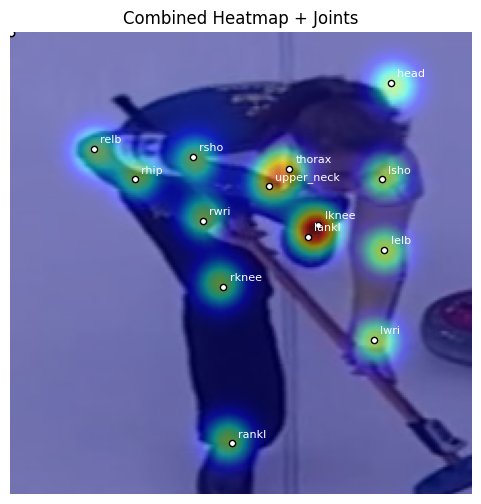

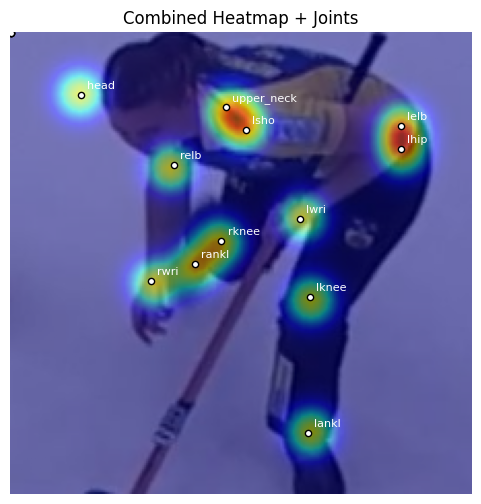

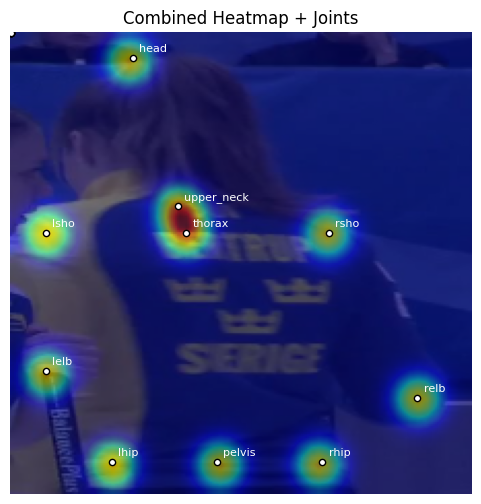

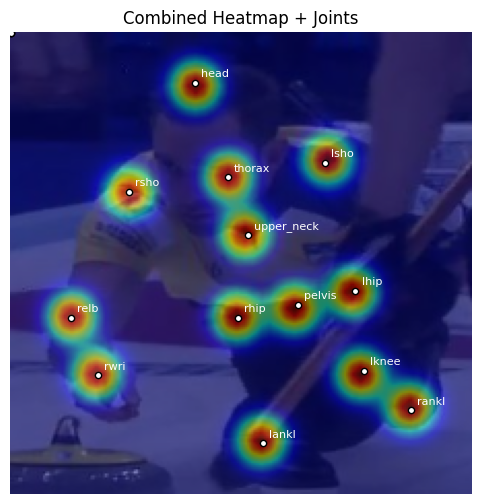

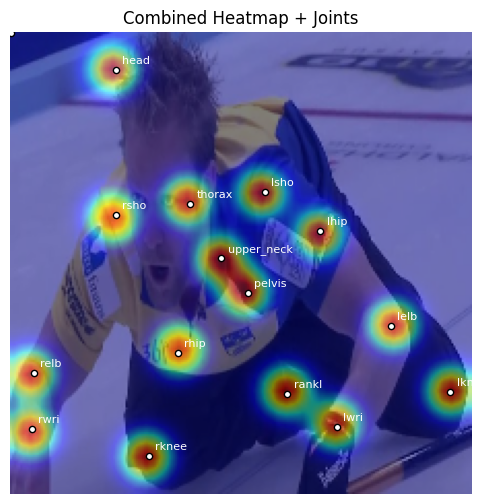

In [27]:
from mpii_dataset import MPIIDataset
import matplotlib.pyplot as plt
import torch
import cv2

face_dataset = MPIIDataset(images_path='cropped_persons/',
                            annotations_path='annotations/cropped_persons_annotations.json',
                                    )


mpii_idx_to_jnt = {
    0: 'rankl', 1: 'rknee', 2: 'rhip', 3: 'lhip', 4: 'lknee', 5: 'lankl',
    6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 9: 'head',
    10: 'rwri', 11: 'relb', 12: 'rsho', 13: 'lsho', 14: 'lelb', 15: 'lwri'
}

def show_combined_heatmap_with_joints(image, heatmaps, coords=None, alpha=0.5, joint_names=mpii_idx_to_jnt):
    """
    Overlay all joint heatmaps + optionally draw joint points.

    Args:
        image: (3, H, W) or (H, W, 3)
        heatmaps: (num_joints, Hh, Wh)
        coords: optional (num_joints, 2) normalized joint coordinates in [0,1]
        alpha: transparency for overlay
    """
    # Convert image
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    if image.max() > 1:
        image = image / 255.0

    H, W, _ = image.shape

    # Convert heatmaps
    if isinstance(heatmaps, torch.Tensor):
        heatmaps = heatmaps.detach().cpu().numpy()

    num_joints = heatmaps.shape[0]
    combined_hm = np.zeros((H, W), dtype=np.float32)
    for j in range(num_joints):
        hm = heatmaps[j]
        hm_resized = cv2.resize(hm, (W, H))
        combined_hm += hm_resized
    combined_hm = (combined_hm - combined_hm.min()) / (combined_hm.max() + 1e-6)

    # Overlay combined heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.imshow(combined_hm, cmap='jet', alpha=alpha)

    # Plot joint coordinates
    if coords is not None:
        if isinstance(coords, torch.Tensor):
            coords = coords.detach().cpu().numpy()
        for i, (x, y) in enumerate(coords):
            x_pix, y_pix = int(x * W), int(y * H)
            plt.scatter(x_pix, y_pix, s=20, c='white', edgecolors='black')
            plt.text(x_pix + 3, y_pix - 3, joint_names.get(i, str(i)), color='white', fontsize=8)

    plt.axis('off')
    plt.title("Combined Heatmap + Joints")
    plt.show()




for i, sample in enumerate(face_dataset):
    if i < 5:
        show_combined_heatmap_with_joints(sample['image'], sample['heatmaps'], sample['joints'])
    else:
        break

